In [2]:
import pickle
import numpy as np 
import pandas as pd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib as mpl
import os 
import glob


mpl.rcParams['figure.figsize'] = (5,5)
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams["image.origin"] = 'lower'

In [3]:
model_name = "v17_joinde"
model_dir = "../models/"+model_name
model_version = 2
numpy_version = 1
limit_files = 15
cols = ["seed_eta", "seed_iz","en_seed","et_seed",
        "cluster_deta", "cluster_dphi", "en_cluster", "et_cluster",
       "seed_f5_r9", "seed_f5_sigmaIetaIeta","seed_f5_sigmaIetaIphi","seed_f5_sigmaIphiIphi",
        "seed_f5_swissCross","seed_nxtals", "seed_etaWidth", "seed_phiWidth",
        "cl_f5_r9", "cl_f5_sigmaIetaIeta","cl_f5_sigmaIetaIphi","cl_f5_sigmaIphiIphi",
        "cl_f5_swissCross", "cl_nxtals", "cl_etaWidth", "cl_phiWidth"]

os.makedirs(model_dir, exist_ok = True)
with open("variables.txt", "w") as of:
    of.write("\n".join(cols))

# Data preparation
## Input: 
- E seed
- eta,phi,z seed
- E cluster
- delta_eta,delta_phi,

Filter only windows with the calo

In [4]:
files_ele = f"/storage/ECAL/training_data/wp_comparison/electrons/numpy_wp_ele_v{numpy_version}/training/"
files_gamma = f"/storage/ECAL/training_data/wp_comparison/gammas/numpy_wp_gamma_v{numpy_version}/training/"

In [4]:
files_ele = f"/storage/ECAL/training_data/electrons/numpy_v{numpy_version}/training/"
files_gamma = f"/storage/ECAL/training_data/gammas/numpy_v{numpy_version}/training/"

In [5]:
datas_ele = []

i = 0
for f in glob.glob(files_ele+"*.pkl"):
    if i>limit_files :continue
    d = pickle.load(open(f, "rb"))   
    datas_ele.append(d[d.is_seed == False])
    i+=1
    
data_ele = pd.concat(datas_ele, ignore_index=True)
data_ele["particle"] = "electron"
print("N events ele: ",len(data_ele))

datas_gamma = []
i = 0
for f in glob.glob(files_gamma+"*.pkl"):
    if i>limit_files :continue
    d = pickle.load(open(f, "rb"))  
    datas_gamma.append(d[d.is_seed==False])
    i+=1
    
data_gamma = pd.concat(datas_gamma, ignore_index=True)
data_gamma["particle"] = "gamma"
print("N events gamma: ",len(data_gamma))

if data_ele.shape[0]> data_gamma.shape[0]:
    data = pd.concat([data_gamma, data_ele.iloc[0:len(data_gamma)]], ignore_index=True)
else:
    data = pd.concat([data_gamma.iloc[0:len(data_ele)], data_ele], ignore_index=True)
    
del data_gamma
del data_ele

N events ele:  7497593
N events gamma:  7251791


Balance gamma and electron

In [5]:
data_EB = data[data.seed_iz == 0]
data_EE = data[data.seed_iz != 0]

In [6]:
print("Sample in EB:", len(data[abs(data.seed_eta) <1.479]))
print("Sample in EE:", len(data[abs(data.seed_eta) >=1.479]))
print("Sample in EB in SC:", len(data[(abs(data.seed_eta) <1.479)&(data.in_scluster)]))
print("Sample in EE in SC:", len(data[(abs(data.seed_eta) >=1.479)&(data.in_scluster)]))
print("N in supercluster: ", len(data[ data.in_scluster]))
print("N out supercluster: ", len(data[data.in_scluster == False]))
w = len(data[(data.is_seed == False) & (data.in_scluster == False)]) / len(data[(data.is_seed == False) & (data.in_scluster==True)])
print(w)

Sample in EB: 7399437
Sample in EE: 2563543
Sample in EB in SC: 444591
Sample in EE in SC: 181691
N in supercluster:  626282
N out supercluster:  9336698
14.908137228916047


In [7]:
print("caloMatch samples: ", len(data[data.is_calo_matched]))
print("Not caloMatch samples: ", len(data[data.is_calo_matched ==False]))

caloMatch samples:  1639480
Not caloMatch samples:  8323500


# Data Preparation

In [12]:
if det == "EB":
    data = data_EB
if det == "EE":
    data = data_EE

## Reweighting
Only the classes are reweighted, not in Et/eta bins

In [6]:
w = len(data[(data.is_seed == False) & (data.in_scluster == False)]) / len(data[(data.is_seed == False) & (data.in_scluster==True)])
print("Weight ",w)
data.loc[data.in_scluster,"w"] = w
data.loc[data.in_scluster==False, "w"] = 1.

Weight  14.955377779537937


# Array preparation

In [28]:
data

,calo_seed_index,cl_etaWidth,cl_f5_r9,cl_f5_sigmaIetaIeta,cl_f5_sigmaIetaIphi,cl_f5_sigmaIphiIphi,cl_f5_swissCross,cl_nxtals,cl_phiWidth,cluster_deta,...,seed_f5_swissCross,seed_iz,seed_nxtals,seed_phi,seed_phiWidth,window_index,particle,et_bin,eta_bin,w
1,-1,0.002766,1.000000,0.000000,0.000000,0.000000,1.000000,1,0.002089,-0.016367,...,0.688010,0,3,-2.834352,0.004936,hvlerqxix,gamma,0,3,1.000000
5,2,0.002557,1.000000,0.000000,0.000000,0.000000,1.000000,1,0.001303,0.102629,...,0.238974,0,22,2.334469,0.018377,hwwsnyejt,gamma,8,3,1.000000
6,-1,0.002266,1.647160,0.009259,0.000043,0.008191,0.701537,1,0.001874,-0.158738,...,0.688010,0,3,-2.834352,0.004936,hvlerqxix,gamma,0,3,1.000000
10,2,0.002434,1.000000,0.000000,0.000000,0.000000,1.000000,1,0.001172,0.136999,...,0.238974,0,22,2.334469,0.018377,hwwsnyejt,gamma,8,3,1.000000
11,1,0.002267,1.000000,0.000000,0.000000,0.000000,1.000000,1,0.001510,0.146770,...,0.341402,0,2,-0.967447,0.001695,maaimtxxj,gamma,0,6,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34420905,2,0.002469,1.000000,0.014994,-0.000176,0.014128,0.307549,1,0.008952,-0.184024,...,0.707970,0,1,-0.480436,0.001315,isxkdovpx,electron,0,3,1.000000
34420906,1,0.002529,1.616666,0.018228,0.000150,0.017587,0.663418,1,0.001423,0.001223,...,0.112008,0,2,1.597663,0.014243,vcolwulhq,electron,1,6,16.916718
34420907,1,0.002505,1.249638,0.008355,-0.000112,0.015185,0.750362,3,0.001400,0.018357,...,0.112008,0,2,1.597663,0.014243,vcolwulhq,electron,1,6,16.916718
34420909,-1,0.002163,1.000000,0.000000,0.000000,0.000000,1.000000,1,0.002124,-0.178211,...,1.000000,0,1,-0.864838,0.002363,lxponyheo,electron,0,4,1.000000


In [7]:
X = data[ cols ].values
truth = data[["in_scluster"]].values
y = np.array(truth[:], dtype=int)
weights = data.w.values

In [8]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



In [9]:
pickle.dump(scaler, open(model_dir + "/scaler_model_v{}.pkl".format(model_version), "wb"))

In [9]:
scaler.mean_

array([ 7.02463575e-03, -1.24199275e-02,  1.52806921e-03,  5.81765246e+01,
        2.57289413e+01, -7.38239696e-04, -1.34617199e-04,  1.30394112e+00,
        5.67097515e-01,  1.00777807e+00,  1.35878960e-02, -4.33484837e-06,
        1.71075590e-02,  4.90503419e-01,  5.10130183e+00,  8.82503260e-03,
        1.04085524e-02,  1.92347850e+00,  1.31552897e-02,  1.63385939e-05,
        1.43022597e-02,  5.92813578e-01,  1.49568997e+00,  3.36221652e-03,
        3.06406199e-03])

In [10]:
scaler.scale_

array([1.31379037e+00, 1.80873202e+00, 5.07211178e-01, 9.21428703e+01,
       2.98673042e+01, 1.10279366e-01, 3.30498998e-01, 2.62680772e+00,
       1.16208917e+00, 1.29027118e-01, 1.12036931e-02, 1.86629825e-04,
       1.31007837e-02, 4.02186564e-01, 5.67336346e+00, 6.14557913e-03,
       7.24830585e-03, 7.83988200e+00, 1.70465625e-02, 3.06117345e-04,
       1.80221678e-02, 1.99389927e+00, 1.88835196e+00, 4.12488693e-03,
       4.79731185e-03])

In [9]:
print("N. samples:", X.shape[0])

N. samples: 23560522


In [12]:
X_train, X_val, y_train, y_val, w_train, w_val = train_test_split(X_scaled, y, weights, test_size=0.20,
                                                stratify=y)

### Some plots

# Training

In [10]:
# Import all the required Libraries
import tensorflow
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten, Deconvolution2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam
from keras import callbacks
from keras import backend as K
from keras import regularizers
from keras.callbacks import *

Using TensorFlow backend.


In [15]:
model = Sequential()
model.add(Dense(400, input_dim=X_val.shape[1], activation="relu"))
model.add(Dropout(0.01))
model.add(Dense(400, activation="relu"))
model.add(Dropout(0.01))
#model.add(Dense(300, activation="relu"))
#model.add(Dropout(0.1))
#model.add(Dense(100, activation="relu"))
#model.add(Dropout(0.05))

model.add(Dense(1, activation="sigmoid"))


model.compile(optimizer='adagrad',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 400)               10000     
_________________________________________________________________
dropout_3 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 400)               160400    
_________________________________________________________________
dropout_4 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 401       
Total params: 170,801
Trainable params: 170,801
Non-trainable params: 0
_________________________________________________________________


In [15]:
model = Sequential()
model.add(Dense(300, input_dim=X_val.shape[1], activation="relu",kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.1))
model.add(Dense(200, activation="relu",kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.1))
model.add(Dense(200, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(200, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.05))

model.add(Dense(1, activation="sigmoid"))


model.compile(optimizer='adagrad',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 300)               7800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               60200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 200)              

In [ ]:
model = Sequential()
model.add(Dense(400, input_dim=X_val.shape[1], activation="relu",kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.01))
model.add(Dense(400, activation="relu"))
model.add(Dropout(0.01))
#model.add(Dense(300, activation="relu"))
#model.add(Dropout(0.1))
#model.add(Dense(100, activation="relu"))
#model.add(Dropout(0.05))

model.add(Dense(1, activation="sigmoid"))


model.compile(optimizer='adagrad',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

In [12]:
model = Sequential()
model.add(Dense(300, input_dim=X_val.shape[1], activation="relu",kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.1))
model.add(Dense(300, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(300, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(100, activation="relu"))
model.add(Dropout(0.05))

model.add(Dense(1, activation="sigmoid"))


model.compile(optimizer='adagrad',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 300)               7500      
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_3 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)              

In [23]:
model = Sequential()
model.add(Dense(200, input_dim=X_val.shape[1], activation="relu",kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(200, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(200, activation="relu"))
model.add(Dropout(0.5))
#model.add(Dense(50, activation="relu"))
#model.add(Dropout(0.05))

model.add(Dense(1, activation="sigmoid"))


model.compile(optimizer='adagrad',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               5200      
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [17]:
model = Sequential()
model.add(Dense(300, input_dim=X_val.shape[1], activation="relu",kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.1))
model.add(Dense(200, activation="relu",kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.1))
model.add(Dense(200, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.05))

model.add(Dense(1, activation="sigmoid"))


model.compile(optimizer='adagrad',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 300)               7800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               60200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)               

In [16]:
model = Sequential()
model.add(Dense(200, input_dim=X_val.shape[1], activation="relu",kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.1))
model.add(Dense(100, activation="relu",kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.1))
model.add(Dense(100, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(1, activation="sigmoid"))


model.compile(optimizer='adagrad',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 100)               2600      
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_9 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_10 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 50)               

In [23]:
model = Sequential()
model.add(Dense(200, input_dim=X_val.shape[1], activation="relu",kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.1))
model.add(Dense(100, activation="relu",kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.1))
model.add(Dense(100, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(1, activation="sigmoid"))


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 200)               5200      
_________________________________________________________________
dropout_5 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 50)               

In [50]:
model = Sequential()
model.add(Dense(100, input_dim=X_val.shape[1], activation="relu",kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.1))
model.add(Dense(100, activation="relu",kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.1))
model.add(Dense(100, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(100, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(1, activation="sigmoid"))


model.compile(optimizer='adagrad',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 100)               2200      
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_9 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 100)              

In [23]:
import math
def step_decay(epoch):
    initial_lrate = 1
    drop = 0.5
    epochs_drop = 2.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    if lrate < 0.005: return 0.005
    return lrate

In [11]:
from keras import models
model = models.load_model(model_dir+ "/model_v{}.hd5".format(model_version))
scaler = pickle.load(open(model_dir+ "/scaler_model_v{}.pkl".format(model_version), "rb"))

In [25]:
auto_save = ModelCheckpoint(model_dir+ "/model_v{}.hd5".format(model_version), monitor='val_loss', 
                    verbose=1, save_best_only=True, save_weights_only=False, 
                    mode='auto', period=1)

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, 
                            patience=20, verbose=1)


#lr_scheduler = callbacks.LearningRateScheduler(step_decay, verbose=1)

history = model.fit(
            X_train, y_train,
            sample_weight = w_train,
            batch_size = 4096,
            epochs=600,
           initial_epoch=200,
            shuffle=True,
            validation_data = (X_val, y_val, w_val),
            callbacks = [ auto_save, early_stop ] #lr_scheduler
            )

Train on 11602865 samples, validate on 2900717 samples
Epoch 201/600
11602865/11602865 [==============================] - 53s 5us/step - loss: 0.2201 - accuracy: 0.9498 - val_loss: 0.2252 - val_accuracy: 0.9514

Epoch 00201: val_loss improved from inf to 0.22523, saving model to ../models/v17_joinde/model_v2.hd5
Epoch 202/600
11602865/11602865 [==============================] - 51s 4us/step - loss: 0.2199 - accuracy: 0.9498 - val_loss: 0.2248 - val_accuracy: 0.9494

Epoch 00202: val_loss improved from 0.22523 to 0.22477, saving model to ../models/v17_joinde/model_v2.hd5
Epoch 203/600
11602865/11602865 [==============================] - 51s 4us/step - loss: 0.2198 - accuracy: 0.9499 - val_loss: 0.2251 - val_accuracy: 0.9465

Epoch 00203: val_loss did not improve from 0.22477
Epoch 204/600
11602865/11602865 [==============================] - 52s 4us/step - loss: 0.2198 - accuracy: 0.9499 - val_loss: 0.2247 - val_accuracy: 0.9489

Epoch 00204: val_loss improved from 0.22477 to 0.22471, sa

11602865/11602865 [==============================] - 52s 4us/step - loss: 0.2176 - accuracy: 0.9502 - val_loss: 0.2236 - val_accuracy: 0.9496

Epoch 00236: val_loss improved from 0.22377 to 0.22359, saving model to ../models/v17_joinde/model_v2.hd5
Epoch 237/600
11602865/11602865 [==============================] - 52s 4us/step - loss: 0.2177 - accuracy: 0.9502 - val_loss: 0.2244 - val_accuracy: 0.9499

Epoch 00237: val_loss did not improve from 0.22359
Epoch 238/600
11602865/11602865 [==============================] - 52s 4us/step - loss: 0.2175 - accuracy: 0.9502 - val_loss: 0.2238 - val_accuracy: 0.9492

Epoch 00238: val_loss did not improve from 0.22359
Epoch 239/600
11602865/11602865 [==============================] - 52s 4us/step - loss: 0.2175 - accuracy: 0.9502 - val_loss: 0.2237 - val_accuracy: 0.9486

Epoch 00239: val_loss did not improve from 0.22359
Epoch 240/600
11602865/11602865 [==============================] - 53s 5us/step - loss: 0.2174 - accuracy: 0.9502 - val_loss: 0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



11602865/11602865 [==============================] - 52s 4us/step - loss: 0.2159 - accuracy: 0.9504 - val_loss: 0.2231 - val_accuracy: 0.9508

Epoch 00272: val_loss did not improve from 0.22292
Epoch 273/600
11602865/11602865 [==============================] - 52s 4us/step - loss: 0.2158 - accuracy: 0.9505 - val_loss: 0.2231 - val_accuracy: 0.9499

Epoch 00273: val_loss did not improve from 0.22292
Epoch 274/600
11602865/11602865 [==============================] - 52s 4us/step - loss: 0.2158 - accuracy: 0.9505 - val_loss: 0.2234 - val_accuracy: 0.9522

Epoch 00274: val_loss did not improve from 0.22292
Epoch 275/600
10702848/11602865 [==========================>...] - ETA: 3s - loss: 0.2159 - accuracy: 0.9504

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



11602865/11602865 [==============================] - 52s 4us/step - loss: 0.2154 - accuracy: 0.9505 - val_loss: 0.2230 - val_accuracy: 0.9499

Epoch 00283: val_loss did not improve from 0.22284
Epoch 284/600
11602865/11602865 [==============================] - 52s 5us/step - loss: 0.2155 - accuracy: 0.9505 - val_loss: 0.2228 - val_accuracy: 0.9487

Epoch 00284: val_loss improved from 0.22284 to 0.22284, saving model to ../models/v17_joinde/model_v2.hd5
Epoch 285/600
11602865/11602865 [==============================] - 52s 5us/step - loss: 0.2154 - accuracy: 0.9505 - val_loss: 0.2231 - val_accuracy: 0.9513

Epoch 00285: val_loss did not improve from 0.22284
Epoch 286/600
11602865/11602865 [==============================] - 52s 4us/step - loss: 0.2154 - accuracy: 0.9505 - val_loss: 0.2229 - val_accuracy: 0.9492

Epoch 00286: val_loss did not improve from 0.22284
Epoch 287/600
 2117632/11602865 [====>.........................] - ETA: 40s - loss: 0.2160 - accuracy: 0.9504

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [26]:
hist = history.history


In [27]:
hist

{'val_loss': [0.22522940029441027,
  0.22476733623196665,
  0.2251457854380751,
  0.22470787348407084,
  0.22461411957698096,
  0.22478499895895462,
  0.22493440379054716,
  0.22435247547990014,
  0.2246389330177483,
  0.22469660618244755,
  0.22438416716548837,
  0.2246314817655679,
  0.22452696187290144,
  0.22432100944145786,
  0.2243519657390523,
  0.22427641358103254,
  0.22431639715500035,
  0.2244740793358816,
  0.22424337244735265,
  0.2243032171464194,
  0.22419628949679732,
  0.22420830382392856,
  0.22415201095381784,
  0.22395674047871125,
  0.22397500523078742,
  0.22440979194257304,
  0.22389504684966827,
  0.22411613826007978,
  0.22382836392621117,
  0.22389031798660863,
  0.2238447428576711,
  0.22403516670017215,
  0.22377303339868906,
  0.22382784743461748,
  0.22380547364593611,
  0.22359395930711173,
  0.2243865927716876,
  0.22381584836752252,
  0.2237279983201192,
  0.22379488906032646,
  0.22356303574606745,
  0.22358386872023123,
  0.22381152250988492,
  0.2237

In [28]:
import json
json.dump(str(hist), open(model_dir+"/history2.json", "w"))

In [38]:
auto_save = ModelCheckpoint(model_dir+ "/model_v{}_{}.hd5".format(model_version,det), monitor='val_loss', 
                    verbose=1, save_best_only=True, save_weights_only=False, 
                    mode='auto', period=2)

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, 
                            patience=5, verbose=1)


lr_scheduler = callbacks.LearningRateScheduler(step_decay, verbose=1)

history = model.fit(
            X_train, y_train,
            sample_weight = w_train,
            batch_size = 4096,
            epochs=400,
            shuffle=True,
            validation_data = (X_val, y_val, w_val),
            callbacks = [early_stop, auto_save,lr_scheduler] #lr_scheduler
            )

NameError: name 'step_decay' is not defined

>>> Computing AUC...
AUC score: 0.9912357133705492
>>> Saving ROC curve...


/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


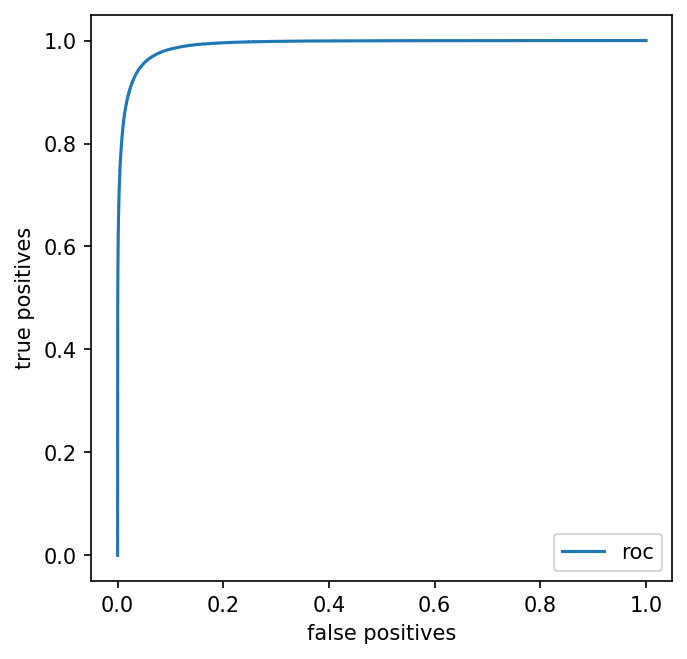

In [29]:
# Evalutation
print(">>> Computing AUC...")

from sklearn.metrics import roc_auc_score, roc_curve

pred = model.predict(X_val,batch_size=2048)
auc = roc_auc_score(y_val, pred, sample_weight=w_val)
print("AUC score: " + str(auc))

print(">>> Saving ROC curve...")
fp , tp, th = roc_curve(y_val, pred, sample_weight=w_val,drop_intermediate=True)
plt.plot(fp, tp, label="roc")
#plt.plot(fp, th, label="threshold")
plt.xlabel("false positives")
plt.ylabel("true positives")
plt.ylim(-0.05,1.05)

plt.legend()

# AUC by eta and Et bin

In [30]:
data["y"] =  model.predict(scaler.transform(data[cols].values), batch_size=4096)

det == "EB"
ets = [0,20,40,60,80,100]
if det=="EB":
    etas = [0, 0.4,0.8, 1.2,1.479]
if det=="EE":
    etas = [1.479,1.75,2.,2.25,3]

data["eta_bin"] = pd.cut(abs(data.seed_eta), etas, labels=list(range(len(etas)-1)))
data["et_bin"] = pd.cut(data.et_seed, ets, labels=list(range(len(ets)-1)))

result =  data.groupby(["eta_bin", "et_bin"]).apply(
        lambda gr:  roc_auc_score(gr.in_scluster, gr.y, sample_weight=gr.w)
)

a = result.values.reshape((len(etas)-1,len(ets)-1))
plt.imshow(a.T)
plt.xlabel("Eta bin")
plt.ylabel("Et bin")
plt.title("AUC")
plt.colorbar()

KeyboardInterrupt: 

In [31]:
from sklearn.metrics import roc_auc_score, roc_curve
data["y"] =  model.predict(scaler.transform(data[cols].values), batch_size=4096)

ets = [0,20,40,60,80,100]
etas = [0, 0.4,0.8, 1.2,1.479, 1.75,2.,2.25,3]

data["eta_bin"] = pd.cut(abs(data.seed_eta), etas, labels=list(range(len(etas)-1)))
data["et_bin"] = pd.cut(data.et_seed, ets, labels=list(range(len(ets)-1)))

result =  data.groupby(["eta_bin", "et_bin"]).apply(
        lambda gr:  roc_auc_score(gr.in_scluster, gr.y, sample_weight=gr.w)
)

a = result.values.reshape((len(etas)-1,len(ets)-1))


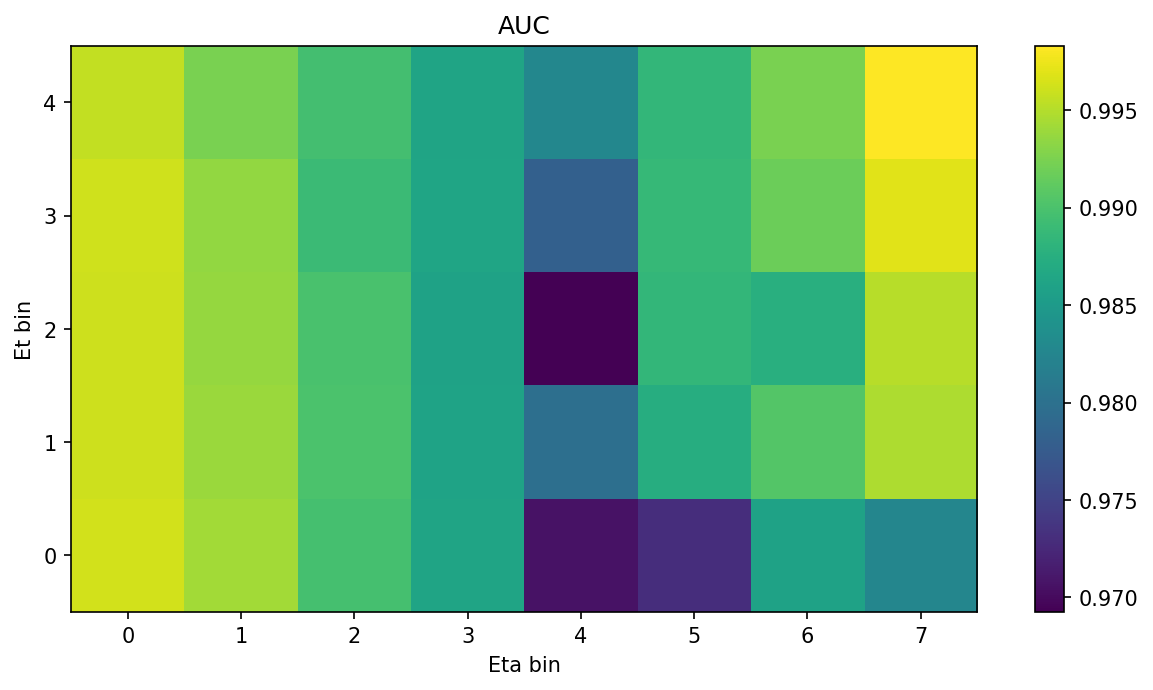

In [32]:
plt.figure(figsize=(10,5))
plt.imshow(a.T)
plt.xlabel("Eta bin")
plt.ylabel("Et bin")
plt.title("AUC")
plt.colorbar()
plt.savefig(model_dir+ "/AUC.png")

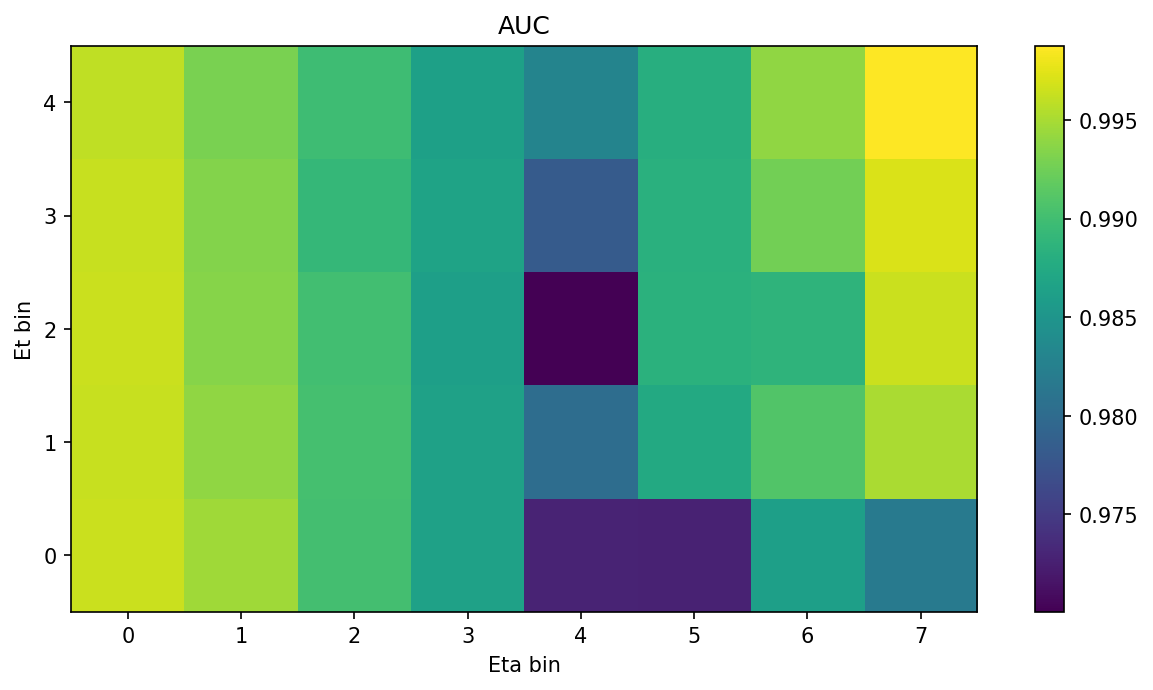

In [16]:
plt.figure(figsize=(10,5))
plt.imshow(a.T)
plt.xlabel("Eta bin")
plt.ylabel("Et bin")
plt.title("AUC")
plt.colorbar()
plt.savefig(model_dir+ "/AUC.png")

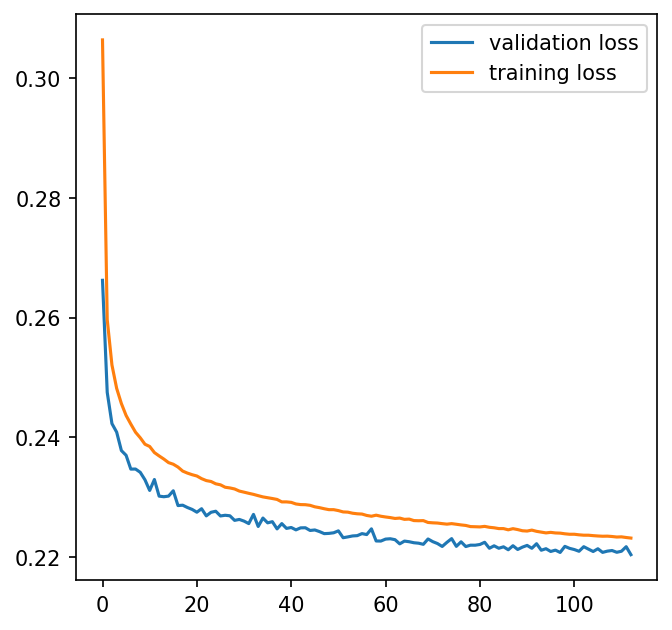

In [17]:
plt.plot(history.epoch, history.history["val_loss"], label="validation loss")
plt.plot(history.epoch, history.history["loss"], label="training loss")
plt.legend()

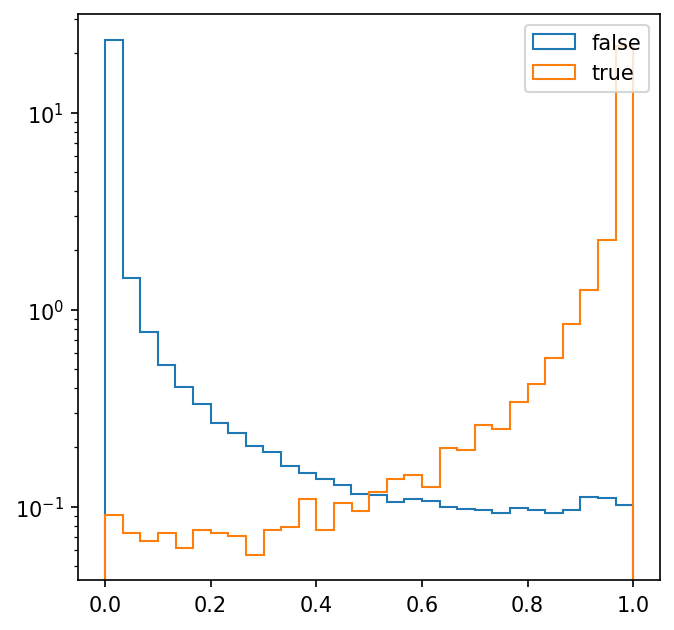

In [16]:
results = model.predict(X_val[:200000])
plt.hist(results[y_val[:200000]==0], bins=30,density=True, label="false", histtype="step")
plt.hist(results[y_val[:200000]==1], bins=30, density=True, label="true", histtype="step")
plt.yscale("log")
plt.legend()

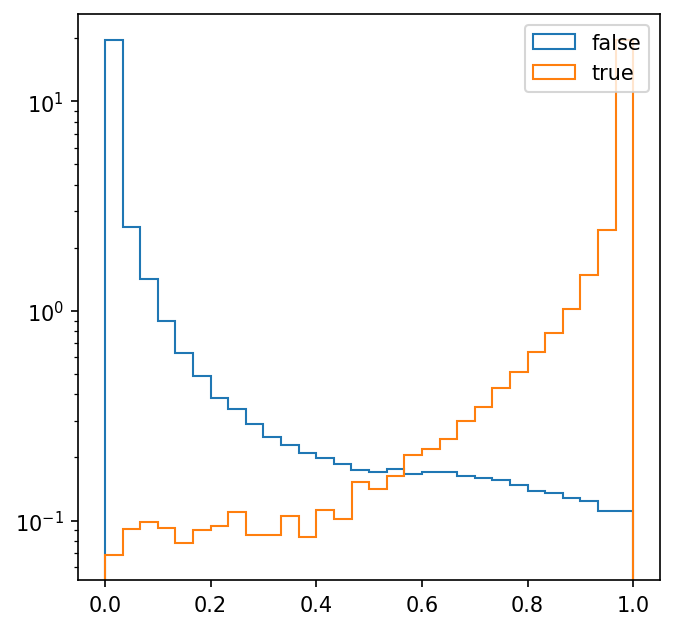

In [28]:
results = model.predict(X_val[:500000])
plt.hist(results[y_val[:500000]==0], bins=30,density=True, label="false", histtype="step")
plt.hist(results[y_val[:500000]==1], bins=30, density=True, label="true", histtype="step")
plt.yscale("log")
plt.legend()

In [25]:
plt.savefig(model_dir +"/output_model_v2_EE.png")

<Figure size 750x750 with 0 Axes>

# Some plots

In [1]:
from keras.models import load_model
model = load_model("models/model11_balanced_100_80_50.hd5")
scaler = pickle.load(open("models/scaler_gamma_electrons.pkl", "rb"))

Using TensorFlow backend.


OSError: Unable to open file (unable to open file: name = 'models/model11_balanced_100_80_50.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
fp , tp, th = roc_curve(y_test, pred)
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
ax1.plot(fp, tp, label="roc", color="blue")

ax1.set_xlabel("Bkg contamination", fontsize=18)
ax1.set_ylabel("Signal efficiency", fontsize=18, color="blue")
ax1.set_ylim(0.850, 1.01)
ax1.set_xlim(0, 0.06)
#ax1.plot([0,1],[1,1],"b--")
ax1.tick_params("y",labelsize="large", labelcolor="blue")

ax2 = ax1.twinx()
ax2.plot(fp, th, label="threshold", color="red")
ax2.tick_params(axis='y', labelcolor="red", labelsize="large")
ax2.set_ylabel("Threshold", fontsize=18, color="red")
ax2.set_ylim(0, 1)
ax1.grid()
#ax2.grid(linestyle="dashed", color="red")

ax2.plot([0.01, 0.01], [0, 2], "g--")
ax2.set_yticks(np.arange(0, 1.1, 0.1))
#ax2.minorticks_on()

ax1.set_title("ROC curve", fontsize=20)
ax2.text(x = 0.048, y = 1.01, s="AUC=0.997", fontsize="large")

fig.tight_layout()

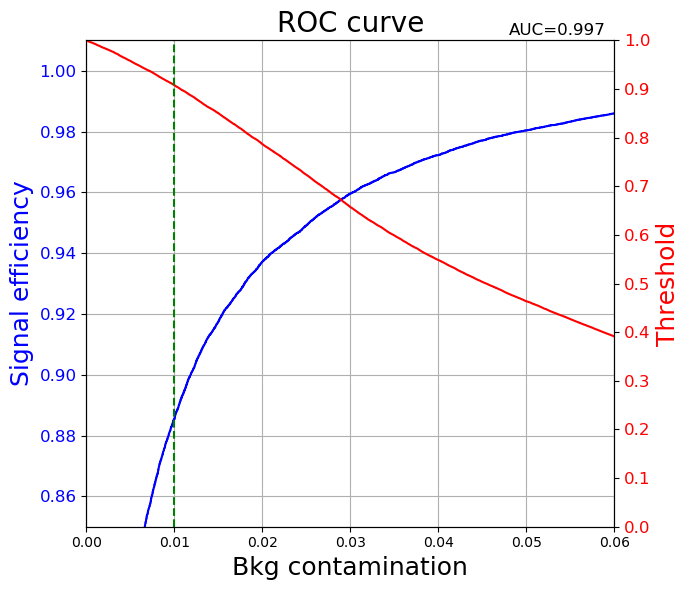

In [36]:
fp , tp, th = roc_curve(y_test, pred)
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
ax1.plot(fp, tp, label="roc", color="blue")

ax1.set_xlabel("Bkg contamination", fontsize=18)
ax1.set_ylabel("Signal efficiency", fontsize=18, color="blue")
ax1.set_ylim(0.850, 1.01)
ax1.set_xlim(0, 0.06)
#ax1.plot([0,1],[1,1],"b--")
ax1.tick_params("y",labelsize="large", labelcolor="blue")

ax2 = ax1.twinx()
ax2.plot(fp, th, label="threshold", color="red")
ax2.tick_params(axis='y', labelcolor="red", labelsize="large")
ax2.set_ylabel("Threshold", fontsize=18, color="red")
ax2.set_ylim(0, 1)
ax1.grid()
#ax2.grid(linestyle="dashed", color="red")

ax2.plot([0.01, 0.01], [0, 2], "g--")
ax2.set_yticks(np.arange(0, 1.1, 0.1))
#ax2.minorticks_on()

ax1.set_title("ROC curve", fontsize=20)
ax2.text(x = 0.048, y = 1.01, s="AUC=0.997", fontsize="large")

fig.tight_layout()